In [8]:
import shapefile as shp
import matplotlib.pyplot as plt
%matplotlib inline

In [40]:
# see: https://stackoverflow.com/a/40494165

import geopandas as gpd
import psycopg2  # (if it is postgres/postgis)

con = psycopg2.connect(
    database="silly_maps", 
    user="lsm",
    host="localhost",
)

sql = """
select 
  geom,
  tractid10, 
  least(
    floor(
      sum(pop10) over (
        partition by '1' 
        order by dist desc
      )/(
        (
          select sum(pop10) 
          from tl_2010_51_tract10
        ) 
        / 11.
      )
    ),
    11 - 1
  ) as distance_district
from
(
  select  
    tracts.geom as geom,
    tracts.countyfp10 || '-' || tracts.tractce10 as tractid10,
    pop10,
    st_distance(
      tracts.center, 
      states.center
    ) as dist
  from
    tl_2010_51_tract10 tracts
    left join cb_2018_us_state_500k states
    on states.name = 'Virginia'
) sub
"""

df = gpd.GeoDataFrame.from_postgis(sql, con, geom_col='geom' )

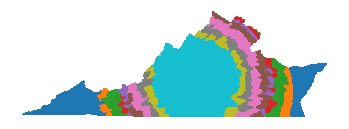

In [58]:
plt = df.plot(column='distance_district', cmap='tab10', antialiased=False)
plt.axis('off')
plt.get_figure().savefig("output.png", dpi=1080)